# Identifying Users With Similar Buying Habits and Preferences

## 1. Data Preprocessing

### Load data

In [2]:
import pandas as pd

aislesDF = pd.read_csv('../data/aisles.csv')
departmentDF = pd.read_csv('../data/departments.csv')
Order_Products_Prior_DF = pd.read_csv('../data/order_products_prior.csv')
Order_Products_Train_DF = pd.read_csv('../data/order_products_train.csv')
ordersDF = pd.read_csv('../data/orders.csv')
productsDF = pd.read_csv('../data/products.csv')


### Merge into one dataframe 

Only keep the users that exist in both 'prior' table and train eval set of 'orders' table.

In [2]:
# orders in prior merged with product names
Order_Product_Name_Prior = pd.merge(Order_Products_Prior_DF, 
                                    productsDF, how='left', on='product_id')
# Prior orders with user_id, product_id, product_name
Prior_User_Order_Product = pd.merge(Order_Product_Name_Prior, 
                                    ordersDF, how='left', on='order_id')

In [3]:
# keep only those that same user_id exists in both train and prior
Prior_User_Order_Product_inner = pd.merge(Prior_User_Order_Product,
                                          ordersDF[ordersDF['eval_set']=='train'][['user_id','eval_set']], 
                                          how='inner', on='user_id')

In [4]:
Prior_User_Order_Product_inner.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set_x,order_number,order_dow,order_hour_of_day,days_since_prior_order,eval_set_y
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,train
1,2,28985,2,1,Michigan Organic Kale,83,4,202279,prior,3,5,9,8.0,train
2,2,9327,3,0,Garlic Powder,104,13,202279,prior,3,5,9,8.0,train
3,2,45918,4,1,Coconut Butter,19,13,202279,prior,3,5,9,8.0,train
4,2,30035,5,0,Natural Sweetener,17,13,202279,prior,3,5,9,8.0,train


## 2. Feature Extraction

The features that will be extracted directly are:
* Mean of order_dow (order placed day of week)
* Mean of order_hour_of_day
* Mean of days_since_prior_order
* Total number of orders made
* Total number of products bought

Then we need another vectorized feature of product name: combine all the products name into one row per user, for word2vec analysis.

In [5]:
user_habit = Prior_User_Order_Product_inner[['user_id','order_id',
                                       'product_name','order_dow',
                                       'order_hour_of_day','days_since_prior_order']]

In [6]:
import numpy as np
# Create a dataframe: average value of each user
user_avg = user_habit.groupby('user_id')['order_dow',
                                'order_hour_of_day',
                                'days_since_prior_order'].agg(np.nanmean)
# Total number of orders of each user
user_order = user_habit.groupby('user_id').order_id.nunique()
user_avg['num_of_orders'] = user_order
# Total number of products of each user
product_number = user_habit.groupby('user_id')['order_id'].agg('count')
user_avg['num_of_products'] = product_number

In [7]:
# add product name to each user
name_list = []
for p_name in user_habit.groupby('user_id')['product_name']:
        name_list.append(' '.join(p_name[1]))

# add the names to dataframe
user_avg['product_name'] = name_list       

In [8]:
# Take a glimpse of the dataset
user_avg.head()

#Prior_User_Order_Product_inner.to_csv("../output/Prior_User_Order_Product_inner.csv")
#user_avg.to_csv('../output/user_avg.csv')

,order_dow,order_hour_of_day,days_since_prior_order,num_of_orders,num_of_products,product_name
user_id,,,,,,
1,2.644068,10.542373,20.259259,10,59,Soda Original Beef Jerky Pistachios Organic St...
2,2.005128,10.441026,15.967033,14,195,Artichoke Spinach Dip Chipotle Beef & Pork Rea...
5,1.621622,15.729730,14.500000,4,37,Uncured Genoa Salami Plain Whole Milk Yogurt W...
7,1.728155,13.631068,13.546392,20,206,85% Lean Ground Beef Organic Apple Slices Appl...
8,4.204082,2.448980,30.000000,3,49,Organic Baby Spinach Michigan Organic Kale Bag...


## 3. Extract Vectorized Text Feature: Use PySpark Word2Vec

In [9]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Word2Vec

spark = SparkSession.builder.appName("User Habit").getOrCreate()

In [4]:
# user_avg = pd.read_csv("../output/user_avg.csv")

In [10]:
product_name_DF = pd.DataFrame(user_avg['product_name'])
# product_documentDF = spark.createDataFrame(product_name_DF)

In [11]:
product_name_DF.head()

,product_name
user_id,
1,Soda Original Beef Jerky Pistachios Organic St...
2,Artichoke Spinach Dip Chipotle Beef & Pork Rea...
5,Uncured Genoa Salami Plain Whole Milk Yogurt W...
7,85% Lean Ground Beef Organic Apple Slices Appl...
8,Organic Baby Spinach Michigan Organic Kale Bag...


In [12]:
# Sample a fraction of data due to large computation
sample_frac = 0.2
product_name_DF_sample  = product_name_DF.sample(frac = sample_frac, random_state=321)
sample_user_id  = product_name_DF_sample.index
print(sample_user_id)

Int64Index([160334,  88565,  79012, 169304,  55886, 116927,  97679,   7855,
            135591,  29129,
            ...
            202726,  56964,  66861, 132464, 114757,  17789, 192164,  82482,
            103592,  47895],
           dtype='int64', name='user_id', length=26242)


In [13]:
dataFrameList = []
for row in product_name_DF_sample['product_name']:
    tup = (row.split(' '),)
    dataFrameList.append(tup)

# Check by the length of output
print(len(dataFrameList))

26242


In [14]:
# Input data of word2vec: Each row is a bag of words from a sentence or document.
N = len(dataFrameList)//100
mod = len(dataFrameList) % 100
documentDF = spark.createDataFrame(dataFrameList[0:100], ["product_name"])

for i in range(1,N):
    documentDF_sub = spark.createDataFrame(dataFrameList[100*i:100*(i+1)], ["product_name"])
    documentDF = documentDF.union(documentDF_sub)
    
documentDF_sub = spark.createDataFrame(dataFrameList[100*N:len(dataFrameList)], ["product_name"])
documentDF = documentDF.union(documentDF_sub)

In [15]:
# Learn a mapping from words to Vectors.
word2Vec = Word2Vec(vectorSize=5, minCount=0, inputCol="product_name", outputCol="result")
model = word2Vec.fit(documentDF)

result = model.transform(documentDF)

In [18]:
# Vectors: densevector
vectorized_features = [ ]
for row in result.collect():
    text, vector = row
    vectorized_features.append(vector)

In [25]:
# Get values from densevector into array
vectorized_features_array=[]
for vectors in vectorized_features:
    vectorized_features_array.append(vectors.values)

In [39]:
# Names of vectorized feature columns
col_names = []
for i in range(1,6):
    name = "vectorized_feature_" + str(i)
    col_names.append(name)
    
# A dataframe: each vectorized feature as one column
vectorized_features_DF = pd.DataFrame(np.array(vectorized_features_array).reshape(len(dataFrameList),5), 
                 columns = col_names)

# Add "user_id" column
vectorized_features_DF['user_id'] = sample_user_id

In [50]:
# Take a glimpse
vectorized_features_DF.head()

,vectorized_feature_1,vectorized_feature_2,vectorized_feature_3,vectorized_feature_4,vectorized_feature_5,user_id
0,-0.282369,-0.182000,0.306287,0.100679,-0.120577,160334
1,0.281474,0.120445,0.273489,-0.253893,-0.660901,88565
2,-0.123565,-0.070204,0.214689,-0.303687,-0.310858,79012
3,-0.218316,-0.182006,0.067302,-0.076648,-0.175688,169304
4,-0.389383,-0.138049,0.040070,-0.079571,-0.091004,55886


## 4. Get All Features: Concatenate with other features in step 2 into one df

In [63]:
# slice user_avg with sampled user_id
user_avg_sampled = user_avg[user_avg.index.isin(sample_user_id)]
# set index as one column 'user_id'
user_avg_sampled.reset_index(level=0, inplace=True)
# merge two dfs on 'user_id'
user_habit_features = pd.merge(user_avg_sampled, vectorized_features_DF, how='inner', on="user_id")
# drop "product_name"
user_habit_features.drop('product_name', axis=1, inplace=True)

In [64]:
# Take a glimpse
user_habit_features.head()

,user_id,order_dow,order_hour_of_day,days_since_prior_order,num_of_orders,num_of_products,vectorized_feature_1,vectorized_feature_2,vectorized_feature_3,vectorized_feature_4,vectorized_feature_5
0,37,3.260638,14.250000,12.687500,23,188,-0.301768,-0.067088,0.302247,0.112837,-0.129281
1,43,2.346939,15.040816,10.549296,11,147,-0.184910,0.093092,0.036534,-0.195309,-0.231066
2,49,2.617021,13.617021,28.522727,8,47,-0.234430,-0.073425,0.100409,-0.179090,-0.092016
3,62,2.850000,13.275000,15.772152,10,80,-0.321395,-0.093903,0.118370,0.169000,-0.197463
4,64,3.888889,15.903704,10.966102,10,135,-0.258294,-0.100414,0.160984,0.075478,-0.148819


In [83]:
#user_habit_features.to_csv('../output/user_habit_features.txt', sep='\t', index=False)
#user_habit_features.to_csv('../output/user_habit_features.csv', sep='\t', index=False)
#user_habit_features_only = user_habit_features.loc[:, 'order_dow':]
#user_habit_features_only.to_csv('../output/user_habit_features_only.txt', sep='\t', index=False)
#user_habit_features_only.to_csv('../output/user_habit_features_only.csv', index=False)

## 5. Cluster Users: PySpark K-Means 

### 5.1 PCA: Reduce features to 2-dimensional

In [97]:
from sklearn.decomposition import PCA
user_habit_features_only = pd.read_csv('../output/user_habit_features_only.csv')
user_habit_features = pd.read_csv('../output/user_habit_features.csv', sep = '\t')
pca = PCA(n_components=2).fit(user_habit_features_only)
pca_2d = pca.transform(user_habit_features_only)

In [98]:
pca_df = pd.DataFrame(pca_2d)
#pca_df.to_csv('../output/pca_feature_df.txt', sep='\t', index=False)
#pca_df.to_csv('../output/pca_feature_df.csv', index=False)
pca_df['user_id'] = user_habit_features['user_id']
#pca_df.to_csv('../output/pca_df.txt', sep='\t', index=False)
#pca_df.to_csv('../output/pca_df.csv', index=False)

### Find the optimal K

In [99]:
# Load and parse the data
data_pca = sc.textFile("../output/pca_feature_df.txt")
parsedData_pca = data_pca.map(lambda line: array([float(x) for x in line.split('\t')]))

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

In [100]:
WSSSE_list_pca = []

K_range = range(5,185,5)
for K in K_range:
    
    # Build the model (cluster the data)
    clusters = KMeans.train(parsedData_pca, K, maxIterations=10, initializationMode="random")
    
    WSSSE_pca = parsedData_pca.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    print("====== k:"+str(K)+" -- Within Set Sum of Squared Error = " + str(WSSSE_pca) + "=======")
    WSSSE_list_pca.append(WSSSE_pca)

====== k:5 -- Within Set Sum of Squared Error = 925645.5695087881=======
====== k:10 -- Within Set Sum of Squared Error = 571873.9200253651=======
====== k:15 -- Within Set Sum of Squared Error = 404232.8312967894=======
====== k:20 -- Within Set Sum of Squared Error = 420393.85970603756=======
====== k:25 -- Within Set Sum of Squared Error = 528154.8771568451=======
====== k:30 -- Within Set Sum of Squared Error = 329658.82038827357=======
====== k:35 -- Within Set Sum of Squared Error = 305537.31041853153=======
====== k:40 -- Within Set Sum of Squared Error = 290879.92673649045=======
====== k:45 -- Within Set Sum of Squared Error = 301790.2795253965=======
====== k:50 -- Within Set Sum of Squared Error = 248299.86312096464=======
====== k:55 -- Within Set Sum of Squared Error = 227716.86435129843=======
====== k:60 -- Within Set Sum of Squared Error = 288854.47049812716=======
====== k:65 -- Within Set Sum of Squared Error = 269758.6048300275=======
====== k:70 -- Within Set Sum of

In [101]:
WSSSE_data_pca = {'K':K_range, "WSSSE": WSSSE_list_pca}
WSSSE_pca_DF = pd.DataFrame(WSSSE_data_pca)

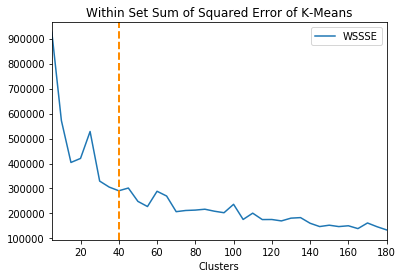

In [212]:
import matplotlib.pyplot as plt
fig = plt.figure()
WSSSE_pca_DF.plot(x='K', y='WSSSE')
plt.axvline(40, 
            color='darkorange', linestyle='dashed', linewidth=2)
plt.xlabel('Clusters')
plt.title('Within Set Sum of Squared Error of K-Means')
plt.show()
#fig.set_dpi(200)
#fig.savefig("../figs/WSSSE_pca.png")

The optimal k is usually one where there is an “elbow” in the WSSSE graph. So choose k = 40.

### Run K-Means with optimal K=40

In [104]:
K_opt = 40
clusters = KMeans.train(parsedData_pca, K_opt, maxIterations=10, initializationMode="random")
#clusters.save(sc, "../output/KMeansModel_pca")
#clusters = KMeansModel.load(sc, "../output/KMeansModel_pca")


### Get the cluster labels

In [105]:
predicted_clusters = clusters.predict(parsedData_pca)
# Into a list
cluster_results = [ ]
for row in predicted_clusters.collect():
    cluster_results.append(row)

### Get the centers for each user

In [158]:
def GetCenter(point):
    center = clusters.centers[clusters.predict(point)]
    return center

centerRDD = parsedData_pca.map(lambda point: GetCenter(point))

center_results = [ ]
for row in centerRDD.collect():
    center_results.append(row)
    
center_results = pd.DataFrame(center_results,columns=['x','y'])

### KMeans Results Summary

In [193]:
kmeans_summary = center_results
kmeans_summary['clusters'] = cluster_results
kmeans_summary['user_id'] = user_habit_features['user_id']

kmeans_summary = pd.merge(pca_df, kmeans_summary ,how='inner', on='user_id')
#kmeans_summary.to_csv("../output/kmeans_summary.csv", header=True)
kmeans_summary.head()

,0,1,user_id,x,y,clusters
0,30.851829,-5.844094,37,18.937511,1.034768,27
1,-10.814946,1.914740,43,-6.878718,-1.092668,10
2,-111.061957,4.096512,49,-114.330476,5.734811,19
3,-77.806557,0.083436,62,-77.620445,-4.536559,5
4,-22.860360,2.186689,64,-29.714480,-1.264748,8


### Visualization of Kmeans Results

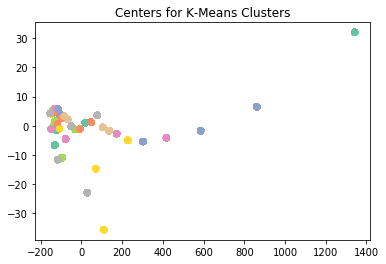

In [201]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure()

# Unique category labels for clusters
color_labels = kmeans_summary['clusters'].unique()

# List of RGB triplets
rgb_values = sns.color_palette("Set2", 40)

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))

# Finally use the mapped values
plt.scatter(kmeans_summary['x'], kmeans_summary['y'], c=kmeans_summary['clusters'].map(color_map))
plt.title("Centers for K-Means Clusters")
plt.show()

#fig.set_dpi(200)
#fig.savefig('../figs/cluster_centers.png')

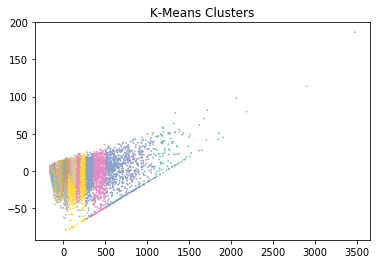

In [266]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure()

# Unique category labels for clusters
color_labels = kmeans_summary['clusters'].unique()

# List of RGB triplets
rgb_values = sns.color_palette("Set2", 40)

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))


# Finally use the mapped values
plt.scatter(kmeans_summary[0], kmeans_summary[1], c=kmeans_summary['clusters'].map(color_map), s = 0.5)
plt.title("K-Means Clusters")
plt.show()

#fig.set_dpi(300)
#fig.savefig('../figs/clusters.png')

In [240]:
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors


colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]

mycolor=sorted_names[3::4]
col_dic = {}
i = 0
for c in mycolor:
    col_dic[i] = c
    i += 1
col_dic[39]='black'

In [253]:
col_df = pd.DataFrame.from_dict(col_dic,'index')
col_df['clusters']=range(40)
col_df.columns = ['color', 'clusters']

In [257]:
kmeans_colors = pd.merge(kmeans_summary,col_df,how='left', on='clusters')

In [267]:
kmeans_colors.head(50)

,0,1,user_id,x,y,clusters,color
0,30.851829,-5.844094,37,18.937511,1.034768,27,steelblue
1,-10.814946,1.914740,43,-6.878718,-1.092668,10,antiquewhite
2,-111.061957,4.096512,49,-114.330476,5.734811,19,limegreen
3,-77.806557,0.083436,62,-77.620445,-4.536559,5,r
4,-22.860360,2.186689,64,-29.714480,-1.264748,8,saddlebrown
5,-110.602221,-3.929755,72,-109.716246,-1.004063,16,yellow
6,109.146611,7.856530,86,104.962112,-0.541459,31,b
7,81.577560,-0.513296,89,78.011492,3.602234,6,tomato
8,-126.409003,-7.409391,93,-130.759966,-6.613759,18,darkseagreen
9,-99.161415,5.454204,102,-96.693934,2.716584,15,lightyellow


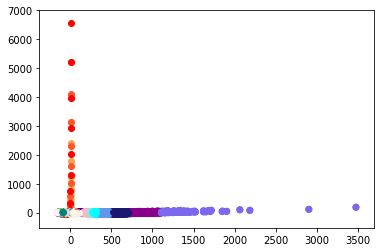

In [265]:
plt.scatter(kmeans_colors[0],kmeans_colors[1],color=kmeans_colors['color'])
plt.show()

In [248]:
[range(0,40)]

[range(0, 40)]

### 5.2 No dimensional reduction: all 9 features

In [85]:
from numpy import array
from math import sqrt

from pyspark.mllib.clustering import KMeans, KMeansModel
from pyspark import SparkContext

sc = SparkContext.getOrCreate()

# Load and parse the data
data = sc.textFile("../output/user_habit_features_only.txt")
parsedData = data.map(lambda line: array([float(x) for x in line.split('\t')]))

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

### Find the optimal K

In [ ]:
WSSSE_list = []

K_range = range(5,185,5)
for K in K_range:
    
    # Build the model (cluster the data)
    clusters = KMeans.train(parsedData, K, maxIterations=10, initializationMode="random")
    
    WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    #print("======Within Set Sum of Squared Error = " + str(WSSSE) + "=======")
    WSSSE_list.append(WSSSE)

In [23]:
WSSSE_data = {'K':K_range, "WSSSE": WSSSE_list}
WSSSE_DF = pd.DataFrame(WSSSE_data)

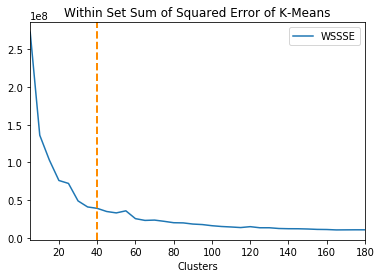

In [34]:
import matplotlib.pyplot as plt
fig = plt.figure()
WSSSE_DF.plot(x='K', y='WSSSE')
plt.axvline(40, 
            color='darkorange', linestyle='dashed', linewidth=2)
plt.xlabel('Clusters')
plt.title('Within Set Sum of Squared Error of K-Means')
plt.show()
#fig.set_dpi(200)
#fig.savefig("../figs/WSSSE.png")

The optimal k is usually one where there is an “elbow” in the WSSSE graph. So choose k = 40.

### Run K-Means with optimal K=40

In [ ]:
K_opt = 40
clusters = KMeans.train(parsedData, K_opt, maxIterations=10, initializationMode="random")